In this notebook, we will train a simple logistic regression model and package it for use in Matlab. 

In [1]:
import os
import pandas as pd

def combine_csv(folder_path, test_condition):
    """
    Combine all CSV files in a folder into a single DataFrame.
    :param folder_path: Path to the folder containing the CSV files
    :param seq_idx: Sequence index
    :param label: Label of the sequence (Normal - 0, Abnormal - 1)
    :return: A single DataFrame containing all the data from the CSV files
    """

    # Get a list of all CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Create an empty DataFrame to store the combined data
    combined_df = pd.DataFrame()

    # Iterate over the CSV files in the folder
    for file in csv_files:
        # Construct the full path to each CSV file
        file_path = os.path.join(folder_path, file)

        # Read each CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Drop the time. Will add later.
        df = df.drop(labels=df.columns[0], axis=1)

        # Extract the file name (excluding the extension) to use as a prefix
        file_name = os.path.splitext(file)[0]

        # Add a prefix to each column based on the file name
        df = df.add_prefix(f'{file_name}_')

        # Concatenate the current DataFrame with the combined DataFrame
        combined_df = pd.concat([combined_df, df], axis=1)

    df = pd.read_csv(file_path)
    combined_df = pd.concat([df['time'], combined_df], axis=1)
    combined_df.loc[:, 'test_condition'] = test_condition

    return combined_df
        

In [2]:
# Read the data
path_training = ['static_with_fault_1', 'static_with_fault_2', 'static_with_fault_3', 
'static_with_fault_4', 'static_with_fault_5', 'static_with_fault_6', 
'steady_state_after_movement', 'steady_state_not_moving'
]
path_header = '../data_collection/collected_data/'

df = pd.DataFrame()
for tmp_path in path_training:
    path = path_header + tmp_path
    tmp_df = combine_csv(path, tmp_path)
    df = pd.concat([df, tmp_df])
    df = df.reset_index(drop=True)

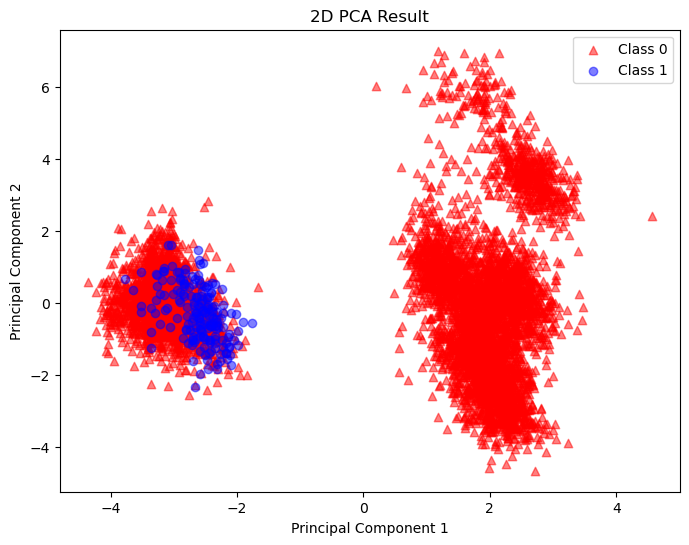

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Separate the features (X) and the target variable (y)
X = df.drop(['test_condition', 'time', 'data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label', 
             'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label'], axis=1)
y = df['data_motor_1_label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA to reduce the dimensionality to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', marker='^', alpha=.5, label='Class 0')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', marker='o', alpha=.5, label='Class 1')
plt.title('2D PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming you have a dataset named 'X' containing features and 'y' containing labels
# Replace X, y with your actual dataset

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with Standardization and Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

# Define hyperparameters for grid search
param_grid = {'classifier__C': np.logspace(-1, 1, 5)}

# Use GridSearchCV to find the best hyperparameters and fit the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Use grid_search.predict to make predictions on the testing dataset
y_pred = grid_search.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Compute precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Compute recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")


c:\Users\Zhiguo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Zhiguo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Confusion Matrix:
[[1224   33]
 [   1   44]]
Accuracy: 0.9738863287250384
Precision: 0.5714285714285714
Recall: 0.9777777777777777
F1 Score: 0.721311475409836


Can you try to train on the training dataset, except for the "task_fault"? And you test on "task_fault" only?

Now let's output the model to a file. Later, this file will be used in the Matlab GUI for real-time prediction.

In [5]:
import joblib


file_name = 'clf_mdl.joblib'
joblib.dump(grid_search, file_name)

['clf_mdl.joblib']

We can load the model and see if it works. Note that the classification is made using clf, which is loaded from your device.

In [1]:
import joblib

file_name = 'clf_mdl.joblib'

clf = joblib.load(file_name)
y_pred = clf.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Compute precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Compute recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

NameError: name 'file_name' is not defined